# Emotion Recognition - Course end Project

##Objective:

To build a model using a convolutional neural network that can classify a person's emotion

## Dataset description:

The dataset contains two folders named Train and Test. These folders have approximately 35,000 images of seven different human emotions, such as anger, disgust, fear, happiness, neutral, sadness, and surprise.



Train folder: This folder has images for training the model, which is divided into subfolders having the same name as the class.

Test folder: This folder has images for testing the model, which is divided into subfolders having the same name as the class.

In [2]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import sklearn.metrics as metric


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from keras.api._v2.keras import activations
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# !unzip /content/Dataset_Emotion_Recognition.zip

In [4]:
train_data_dir = pathlib.Path('data/train/')
test_data_dir = pathlib.Path('data/test/')

In [5]:
tr_image_count = len(list(train_data_dir.glob('*/*.jpg')))
te_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(tr_image_count,te_image_count)

28820 7066


In [ ]:
emotions = ('angry','disgust','fear','happy','neutral','sad','surprise')


In [ ]:
# Plot sample images for all the classes
# fig, axes = plt.subplots(7,1, figsize=(10,10))
for emotion_sample in emotions:
 path= '{}/*'.format(emotion_sample)
 emo_imgs = list(train_data_dir.glob(path))
 plt.figure()
 plt.title(emotion_sample)
 img= cv2.imread(str(emo_imgs[0]))
 plt.imshow(img)


<BarContainer object of 7 artists>

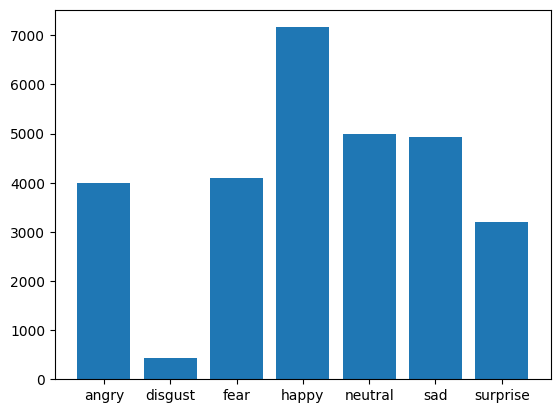

In [ ]:
# Plot the bar graph for the number of images in each class for both training and testing data
# training data
freq = []

for emotion_sample in emotions:
 path= '{}/*'.format(emotion_sample)
 emo = list(train_data_dir.glob(path))
 for i in range(len(emo)):
  i=i+1
 freq.append(i)

plt.bar(x=emotions,height=freq)

In [ ]:
# testing data
freq = []

for emotion_sample in emotions:
 path= '{}/*'.format(emotion_sample)
 emo = list(test_data_dir.glob(path))
 for i in range(len(emo)):
  i=i+1
 freq.append(i)

plt.bar(x=emotions,height=freq)

In [6]:
batch_size = 32

In [7]:
# Build a data augmentation for train data to create new data with translation, rescale and flip,
#  and rotation transformations. Rescale the image at 48x48
training_data_gen=tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
)

# Build a data augmentation for test data to create new data and rescale the image at 48x48
test_data_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
# Read images directly from the train folder and test folder using the appropriate function

train_ds = training_data_gen.flow_from_directory(
  train_data_dir,
  seed=123,
   target_size=(48,48),
  batch_size=batch_size,
  class_mode='categorical')

Found 28820 images belonging to 7 classes.


In [9]:
test_ds= test_data_gen.flow_from_directory(
  test_data_dir,
  seed=123,
   target_size=(48,48),
  batch_size=batch_size,
  class_mode='categorical')

Found 7066 images belonging to 7 classes.


In [10]:
print(train_ds.image_shape)
print(test_ds.image_shape)

(48, 48, 3)
(48, 48, 3)


In [ ]:
test_ds[1]

In [ ]:
test_ds.dtype
len(test_ds.classes)

7066

## Build 3 CNN model with:

### 1- CNN Architecture:


##### color model

In [ ]:
# kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to  specify the same value for all spatial dimensions.
# "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.

model= Sequential([

      layers.Input(shape=(48,48,3)),

     layers.Conv2D(filters=64,kernel_size= 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.Conv2D(64, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2,2)),
     layers.Dropout(0.2),


     layers.Conv2D(64,3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.Conv2D(64, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2,2)),
     layers.Dropout(0.2),

     layers.Conv2D(128, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.Conv2D(128, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2,2)),
     layers.Dropout(0.2),


     layers.Flatten(),
     layers.Dense(256, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.2),
     layers.Dense(128, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.2),
     layers.Dense(7,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
# CategoricalCrossentropy:softmax produce a probability vector
#  from_logits=False; default, we assume that y_pred encodes a probability distribution.

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=8,  restore_best_weights=True)
history= model.fit(train_ds,epochs=10, validation_data=(test_ds),callbacks=[es])

Epoch 1/10
901/901 [==============================] - 1010s 1s/step - loss: 1.9040 - accuracy: 0.2600 - val_loss: 1.6518 - val_accuracy: 0.3494
Epoch 2/10
901/901 [==============================] - 989s 1s/step - loss: 1.6395 - accuracy: 0.3500 - val_loss: 1.6492 - val_accuracy: 0.3438
Epoch 3/10
901/901 [==============================] - 989s 1s/step - loss: 1.4966 - accuracy: 0.4179 - val_loss: 1.3826 - val_accuracy: 0.4658
Epoch 4/10
901/901 [==============================] - 1025s 1s/step - loss: 1.4210 - accuracy: 0.4517 - val_loss: 1.5151 - val_accuracy: 0.4070
Epoch 5/10
901/901 [==============================] - 1020s 1s/step - loss: 1.3539 - accuracy: 0.4812 - val_loss: 1.2918 - val_accuracy: 0.5033
Epoch 6/10
901/901 [==============================] - 1020s 1s/step - loss: 1.3125 - accuracy: 0.5013 - val_loss: 1.1960 - val_accuracy: 0.5405
Epoch 7/10
901/901 [==============================] - 997s 1s/step - loss: 1.2661 - accuracy: 0.5156 - val_loss: 1.2557 - val_accuracy: 0.

In [ ]:
score = model.evaluate(test_ds)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

221/221 [==============================] - 69s 311ms/step - loss: 1.1197 - accuracy: 0.5729
[1.1197162866592407, 0.5728842616081238]
Test loss: 1.1197162866592407
Test accuracy: 0.5728842616081238


In [ ]:
plt.plot(history.history['val_accuracy'],label='test')
plt.plot(history.history['accuracy'],label='train')
plt.legend()

In [ ]:
plt.figure(figsize=(10, 10))
for emotion_sample in emotions:
 path= '{}/*'.format(emotion_sample)
 emo_imgs = list(test_data_dir.glob(path))
 plt.figure()
 img= cv2.imread(str(emo_imgs[8]))
 plt.imshow(img)
 # accurcy
 img_array = tf.keras.utils.img_to_array(img)
 img_array = tf.expand_dims(img_array, 0) # Create a batch
 pred=model.predict(img_array)
 score = tf.nn.softmax(pred[0])
 plt.title( "This image most likely belongs to {} class with a {:.2f} percent confidence."
    .format(emotions[np.argmax(score)], 100 * np.max(score))
    )



In [ ]:
predictions=model.predict_generator(test_ds,steps=221)

<ipython-input-71-0f0f00564e4e>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=model.predict_generator(test_ds,steps=221)


In [ ]:
val_preds = np.argmax(predictions, axis=-1)
true_lebals=test_ds.classes

# label names
# emotions[]
labels = test_ds.class_indices.keys()
precisions, recall, f1_score, _ = metric.precision_recall_fscore_support(true_lebals, val_preds)

In [ ]:
precisions

array([0.1403118 , 0.        , 0.12912088, 0.25238362, 0.17797888,
       0.16150943, 0.12642045])

In [ ]:
recall

array([0.13125   , 0.        , 0.04616896, 0.24657534, 0.29111842,
       0.18788411, 0.11166876])

In [ ]:
f1_score

array([0.13562971, 0.        , 0.06801737, 0.24944568, 0.22090484,
       0.1737013 , 0.11858761])

In [ ]:
model.save('colorModel1.h5',overwrite=True)

In [ ]:
model=tf.keras.models.load_model('/content/colorModel1.h5',compile=True)

#### grayscale model

In [ ]:

train_grayDS = training_data_gen.flow_from_directory(
  train_data_dir,
  seed=123,
  target_size=(48,48),
  batch_size=batch_size,
  color_mode='grayscale',
  class_mode='categorical')

test_grayDS= test_data_gen.flow_from_directory(
  test_data_dir,
  seed=123,
   target_size=(48,48),
  batch_size=batch_size,
   color_mode='grayscale',
  class_mode='categorical')

Found 28820 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
print(train_grayDS.image_shape)
print(test_grayDS.image_shape)
print(test_grayDS.dtype)
len(test_grayDS.classes)

(48, 48, 1)
(48, 48, 1)
float32


7066

In [ ]:

Gscale_model= Sequential([


      layers.Input(shape=(48,48,1)),

     layers.Conv2D(filters=64,kernel_size= 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.Conv2D(64, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2,2)),
     layers.Dropout(0.2),


     layers.Conv2D(64,3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.Conv2D(64, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2,2)),
     layers.Dropout(0.2),

     layers.Conv2D(128, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.Conv2D(128, 3, padding='same', activation='relu'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2,2)),
     layers.Dropout(0.2),


     layers.Flatten(),
     layers.Dense(256, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.2),
     layers.Dense(128, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.2),
     layers.Dense(7,activation='softmax')
])
Gscale_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
Gscale_model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=8,  restore_best_weights=True)
history= Gscale_model.fit(train_grayDS,epochs=10, validation_data=(test_grayDS),callbacks=[es])

In [ ]:
score = Gscale_model.evaluate(test_grayDS)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

221/221 [==============================] - 57s 259ms/step - loss: 1.0789 - accuracy: 0.5894
[1.0788949728012085, 0.5894423723220825]
Test loss: 1.0788949728012085
Test accuracy: 0.5894423723220825


In [ ]:
plt.plot(history.history['val_accuracy'],label='test')
plt.plot(history.history['accuracy'],label='train')
plt.legend()

In [ ]:
labels

dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [ ]:
predictions=Gscale_model.predict_generator(test_grayDS,steps=221)

In [ ]:
val_preds = np.argmax(predictions, axis=-1)
true_lebals=test_grayDS.classes

# label names
# emotions[]
labels = test_grayDS.class_indices.keys()
precisions, recall, f1_score, _ = metric.precision_recall_fscore_support(true_lebals, val_preds)


In [ ]:
f1_score
# for each class with the corresponding order

array([0.15099715, 0.02469136, 0.06521739, 0.24776721, 0.19716408,
       0.16184486, 0.12969283])

In [ ]:
recall

array([0.165625  , 0.01801802, 0.04125737, 0.23561644, 0.24013158,
       0.16944688, 0.14303639])

In [ ]:
precisions

array([0.13874346, 0.03921569, 0.15555556, 0.26123937, 0.1672394 ,
       0.15489567, 0.11862643])

In [ ]:
Gscale_model.save('GrayScaleModel1.h5',overwrite=True)

#### compare colora and grayscale model
Observe the precision, recall the F1-score for all classes for both grayscale and color models

- there is no significant difference bettwen the 2 models,comparison table in writeup file


### 2-Customized CNN Architecture:




#### color model

In [ ]:
train_ds2 = training_data_gen.flow_from_directory(
  train_data_dir,
  seed=123,
   target_size=(48,48),
  batch_size=64,
  class_mode='categorical')

Found 28820 images belonging to 7 classes.


In [ ]:
test_ds2= test_data_gen.flow_from_directory(
  test_data_dir,
  seed=123,
   target_size=(48,48),
  batch_size=64,
  class_mode='categorical')

Found 7066 images belonging to 7 classes.


In [ ]:
loaded_model=tf.keras.models.load_model('/content/colorModel1.h5',compile=True)

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
loaded_model.layers

In [ ]:
# remove the FC layers
inputs = keras.Input((48, 48,3))
x = inputs
for layer in loaded_model.layers[0:-8]:
  # [0:-3]: cut the last 6 FC layer
  x = loaded_model.get_layer(layer.name)(x)
# x=batch_normalization_12 > store the last layer after removing the FC layers to constract the new model

ColorModel_2 = keras.Model(inputs,x)
ColorModel_2.summary()

In [ ]:
# make sure the model is loaded correctly
score = loaded_model.evaluate(test_ds2)
print(score)
print(ColorModel_2.layers[1].get_weights())

111/111 [==============================] - 68s 610ms/step - loss: 1.1197 - accuracy: 0.5729
[1.1197162866592407, 0.5728842616081238]
[array([[[[-0.05176017, -0.05215718, -0.03854483, ...,  0.05095476,
          -0.06018477, -0.03045554],
         [ 0.04833088,  0.01096496,  0.01280343, ..., -0.1021501 ,
           0.06015359, -0.14220192],
         [-0.02046627, -0.13624652,  0.05681546, ...,  0.05082884,
           0.11147206, -0.09368393]],

        [[-0.09411853, -0.06933689, -0.01482794, ..., -0.02447126,
           0.00649379, -0.08965104],
         [-0.07688605, -0.03349625,  0.03839524, ...,  0.01524146,
           0.12401757, -0.07888214],
         [ 0.00177524,  0.04041176, -0.05428077, ..., -0.06415985,
           0.00524954, -0.04012972]],

        [[-0.04491377, -0.0606555 , -0.04783056, ..., -0.05778052,
           0.12269527, -0.04441676],
         [ 0.03987332, -0.02476249, -0.05983891, ..., -0.01187872,
           0.08264876,  0.09860528],
         [-0.03363304, -0.0525

In [ ]:
loaded_model.trainable = False

inputs = keras.Input((48, 48, 3))
x = inputs

for layer in loaded_model.layers[0:-8]:
  x = loaded_model.get_layer(layer.name)(x)

# a general rule of thumb with neural networks. Deeper is better than wider so it is best to not increase the #filters /kernal size too much



x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x =layers.Dropout(0.2)(x)



x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x =keras.layers.MaxPooling2D((2,2))(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x =keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x =keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)


x=layers.Flatten()(x)
x=layers.Dense(1024, activation='relu')(x)
x=layers.BatchNormalization()(x)
x=layers.Dense(512, activation='relu')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(7,activation='softmax')(x)

ColorModel_2 = keras.Model(inputs,x)
ColorModel_2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0  

In [ ]:
# activation function and optimizer as rmsprop and observe if the accuracy increases
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# A lower learning rate means more training time
ColorModel_2.compile(tf.keras.optimizers.Adam(lr_schedule), loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
es_2 = EarlyStopping(monitor='accuracy', mode='max', patience=2,  restore_best_weights=True)

ColorModel_2.fit(train_ds2,epochs=10,batch_size=64,validation_data=(test_ds2),callbacks=[es_2])

# batch_size=16 cause the model to be less accurate

Epoch 1/10
451/451 [==============================] - 715s 2s/step - loss: 1.6928 - accuracy: 0.3810 - val_loss: 2.2722 - val_accuracy: 0.3872
Epoch 2/10
451/451 [==============================] - 685s 2s/step - loss: 1.4776 - accuracy: 0.4466 - val_loss: 1.3475 - val_accuracy: 0.4785
Epoch 3/10
451/451 [==============================] - 693s 2s/step - loss: 1.3891 - accuracy: 0.4772 - val_loss: 1.2791 - val_accuracy: 0.5225
Epoch 4/10
451/451 [==============================] - 692s 2s/step - loss: 1.3172 - accuracy: 0.5010 - val_loss: 1.2639 - val_accuracy: 0.5374
Epoch 5/10
451/451 [==============================] - 691s 2s/step - loss: 1.3000 - accuracy: 0.5097 - val_loss: 1.2561 - val_accuracy: 0.5355
Epoch 6/10
451/451 [==============================] - 692s 2s/step - loss: 1.2746 - accuracy: 0.5243 - val_loss: 1.2114 - val_accuracy: 0.5391
Epoch 7/10
451/451 [==============================] - 693s 2s/step - loss: 1.2639 - accuracy: 0.5217 - val_loss: 1.2203 - val_accuracy: 0.5509

In [ ]:
score = ColorModel_2.evaluate(test_ds2)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


111/111 [==============================] - 115s 1s/step - loss: 1.1768 - accuracy: 0.5600
[1.176783561706543, 0.5600056648254395]
Test loss: 1.176783561706543
Test accuracy: 0.5600056648254395


In [ ]:
ColorModel_2.save('ColorModel_2.h5',overwrite=True)

In [ ]:
predictions=ColorModel_2.predict_generator(test_ds2,steps=111)

<ipython-input-88-f5dbfe928c39>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=ColorModel_2.predict_generator(test_ds2,steps=111)


In [ ]:
val_preds = np.argmax(predictions, axis=-1)
true_lebals=test_ds2.classes

precisions, recall, f1_score, _ = metric.precision_recall_fscore_support(true_lebals, val_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precisions

array([0.11166253, 0.        , 0.17692308, 0.25629792, 0.17074878,
       0.15252666, 0.10167131])

In [ ]:
recall

array([0.09375   , 0.        , 0.02259332, 0.25643836, 0.20065789,
       0.28884987, 0.09159348])

In [ ]:
f1_score

array([0.10192525, 0.        , 0.04006969, 0.25636812, 0.18449905,
       0.19963592, 0.09636964])

#### grayscale model

In [ ]:
train_grayDS2 = training_data_gen.flow_from_directory(
  train_data_dir,
  seed=123,
  target_size=(48,48),
  batch_size=64,
  color_mode='grayscale',
  class_mode='categorical')

test_grayDS2= test_data_gen.flow_from_directory(
  test_data_dir,
  seed=123,
   target_size=(48,48),
  batch_size=64,
   color_mode='grayscale',
  class_mode='categorical')

Found 28820 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
loaded_model2=tf.keras.models.load_model('/content/GrayScaleModel1.h5',compile=True)

In [ ]:
# remove the FC layers
inputs = keras.Input((48, 48,1))
x = inputs
for layer in loaded_model2.layers[0:-8]:
  # [0:-3]: cut the last 6 FC layer
  x = loaded_model2.get_layer(layer.name)(x)
# x=batch_normalization_12 > store the last layer after removing the FC layers to constract the new model

GrayModel_2 = keras.Model(inputs,x)
GrayModel_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0   

In [ ]:

loaded_model2.trainable = False

inputs = keras.Input((48, 48, 1))
x = inputs

for layer in loaded_model2.layers[0:-8]:
  x = loaded_model2.get_layer(layer.name)(x)


x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x =layers.Dropout(0.2)(x)



x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x =keras.layers.MaxPooling2D((2,2))(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x =keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256,3,padding='same',activation='relu')(x)
x =layers.BatchNormalization()(x)
x =keras.layers.MaxPooling2D(strides=1 , padding='same')(x)
x =layers.Dropout(0.2)(x)


x=layers.Flatten()(x)
x=layers.Dense(1024, activation='relu')(x)
x=layers.BatchNormalization()(x)
x=layers.Dense(512, activation='relu')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(7,activation='softmax')(x)

GrayModel_2 = keras.Model(inputs,x)
GrayModel_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0   

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
GrayModel_2.compile(tf.keras.optimizers.Adam(lr_schedule), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=GrayModel_2.fit(train_grayDS2,epochs=10,batch_size=64,validation_data=(test_grayDS2),callbacks=[es_2])

Epoch 1/10
451/451 [==============================] - 649s 1s/step - loss: 1.6469 - accuracy: 0.3800 - val_loss: 1.6246 - val_accuracy: 0.3912
Epoch 2/10
451/451 [==============================] - 640s 1s/step - loss: 1.4388 - accuracy: 0.4410 - val_loss: 1.3836 - val_accuracy: 0.4890
Epoch 3/10
451/451 [==============================] - 609s 1s/step - loss: 1.3483 - accuracy: 0.4902 - val_loss: 1.3779 - val_accuracy: 0.4966
Epoch 4/10
451/451 [==============================] - 609s 1s/step - loss: 1.2804 - accuracy: 0.5188 - val_loss: 1.2967 - val_accuracy: 0.5194
Epoch 5/10
451/451 [==============================] - 613s 1s/step - loss: 1.2531 - accuracy: 0.5315 - val_loss: 1.2765 - val_accuracy: 0.5201
Epoch 6/10
451/451 [==============================] - 630s 1s/step - loss: 1.2319 - accuracy: 0.5370 - val_loss: 1.2030 - val_accuracy: 0.5560
Epoch 7/10
451/451 [==============================] - 636s 1s/step - loss: 1.2274 - accuracy: 0.5410 - val_loss: 1.2627 - val_accuracy: 0.5297

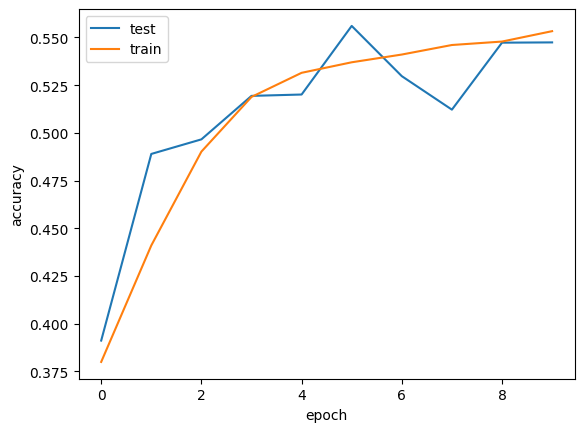

In [ ]:
plt.plot(history.history['val_accuracy'],label='test')
plt.plot(history.history['accuracy'],label='train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

In [ ]:
score = GrayModel_2.evaluate(test_grayDS2)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

111/111 [==============================] - 64s 581ms/step - loss: 1.2384 - accuracy: 0.5474
[1.2383558750152588, 0.5474101305007935]
Test loss: 1.2383558750152588
Test accuracy: 0.5474101305007935


In [ ]:
GrayModel_2.save('GrayModel_2.h5',overwrite=True)

In [ ]:
predictions=GrayModel_2.predict_generator(test_grayDS2,steps=111)

<ipython-input-69-8aa967d89f4c>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=GrayModel_2.predict_generator(test_grayDS2,steps=111)


In [ ]:
val_preds = np.argmax(predictions, axis=-1)
true_lebals=test_grayDS2.classes

precisions, recall, f1_score, _ = metric.precision_recall_fscore_support(true_lebals, val_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precisions

array([0.14845705, 0.        , 0.15483871, 0.27037466, 0.1829204 ,
       0.18333333, 0.12600536])

In [ ]:
recall

array([0.18541667, 0.        , 0.02357564, 0.38356164, 0.28536184,
       0.07726076, 0.11794228])

In [ ]:
f1_score

array([0.16489115, 0.        , 0.04092072, 0.31717263, 0.22293607,
       0.10870908, 0.12184057])

#### compare colora and grayscale model
Observe the precision, recall the F1-score for all classes for both grayscale and color models

- there is no significant difference bettwen the 2 models,comparison table in writeup file

### 3-Transfer Learning:


#### VGG16 model

In [11]:
VGG16_= VGG16(
    include_top=False,
    weights='imagenet',
  # 'imagenet' (pre-training on ImageNet)
)

VGG16_.trainable = False ## Not trainable weights

VGG16_.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [12]:
#Use the generated model

input = layers.Input(shape=(48,48, 3))
output_vgg16_conv = VGG16_(input)

#Add the fully-connected layers
x = layers.Flatten()(output_vgg16_conv)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(7, activation='softmax')(x)

#Create your own model
MyVGG16_model = keras.Model(input,x)
MyVGG16_model.summary()
# weights and layers from VGG part are be hidden

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 15,247,175
Trainable params: 532,487
Non-traina

In [13]:
MyVGG16_model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [14]:
es_3 = EarlyStopping( monitor='val_accuracy', mode='min', patience=2,  restore_best_weights=True)
history=MyVGG16_model.fit(train_ds,epochs=15,batch_size=32,validation_data=(test_ds),callbacks=[es_3])

Epoch 1/15
901/901 [==============================] - 661s 732ms/step - loss: 1.6919 - accuracy: 0.3250 - val_loss: 1.6225 - val_accuracy: 0.3607
Epoch 2/15
901/901 [==============================] - 657s 730ms/step - loss: 1.6413 - accuracy: 0.3499 - val_loss: 1.5958 - val_accuracy: 0.3752
Epoch 3/15
901/901 [==============================] - 656s 728ms/step - loss: 1.6204 - accuracy: 0.3608 - val_loss: 1.5752 - val_accuracy: 0.3844


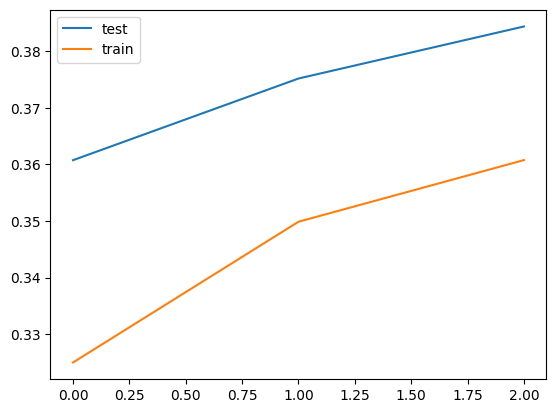

In [15]:
plt.plot(history.history['val_accuracy'],label='test')
plt.plot(history.history['accuracy'],label='train')
plt.legend()

In [36]:
score = MyVGG16_model.evaluate(test_ds)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

221/221 [==============================] - 145s 658ms/step - loss: 1.6225 - accuracy: 0.3607
[1.6225448846817017, 0.36074158549308777]
Test loss: 1.6225448846817017
Test accuracy: 0.36074158549308777


In [16]:
predictions=MyVGG16_model.predict_generator(test_ds,steps=221)

<ipython-input-16-8828a6bbf1f7>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=MyVGG16_model.predict_generator(test_ds,steps=221)


In [18]:
val_preds = np.argmax(predictions, axis=-1)
true_lebals=test_ds.classes

precisions, recall, f1_score, _ = metric.precision_recall_fscore_support(true_lebals, val_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
precisions

array([0.13823019, 0.        , 0.13888889, 0.25285714, 0.18232044,
       0.14980916, 0.12842893])

In [21]:
recall

array([0.24895833, 0.        , 0.01964637, 0.38794521, 0.08141447,
       0.13784021, 0.12923463])

In [22]:
f1_score

array([0.17776125, 0.        , 0.03442341, 0.30616216, 0.11256396,
       0.14357567, 0.12883052])

#### NASNetLarge model

In [ ]:
NASNetLarge_= tf.keras.applications.nasnet.NASNetLarge(
    input_shape=(48, 48,3),
    include_top=False,
    weights='imagenet',

)


NASNetLarge_trainable = False ## Not trainable weights

NASNetLarge_.summary()

In [32]:
#Use the generated model

input = layers.Input(shape=(48,48, 3))
output_NASNetLarge_conv = NASNetLarge_(input)

#Add the fully-connected layers
x = layers.Flatten()(output_NASNetLarge_conv)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(7, activation='softmax')(x)

#Create your own model
MyNASNetLarge_model = keras.Model(input,x)
MyNASNetLarge_model.summary()
# weights and layers from VGG part are be hidden

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 NASNet (Functional)         (None, 2, 2, 4032)        84916818  
                                                                 
 flatten_1 (Flatten)         (None, 16128)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              16516096  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 101,440,089
Trainable params: 101,243,421
Non

In [33]:
MyNASNetLarge_model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [34]:
history=MyNASNetLarge_model.fit(train_ds,epochs=15,batch_size=32,validation_data=(test_ds),callbacks=[es_3])

Epoch 1/15
901/901 [==============================] - 5694s 6s/step - loss: 1.7112 - accuracy: 0.3171 - val_loss: 3071586048.0000 - val_accuracy: 0.1128
Epoch 2/15
901/901 [==============================] - 5670s 6s/step - loss: 1.6912 - accuracy: 0.3148 - val_loss: 304872608.0000 - val_accuracy: 0.2583
Epoch 3/15
901/901 [==============================] - 5698s 6s/step - loss: 1.6642 - accuracy: 0.3332 - val_loss: 1269893888.0000 - val_accuracy: 0.2583


In [44]:
score = MyNASNetLarge_model.evaluate(test_ds)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

221/221 [==============================] - 152s 688ms/step - loss: 3071587072.0000 - accuracy: 0.1128
[3071587072.0, 0.11279366165399551]
Test loss: 3071587072.0
Test accuracy: 0.11279366165399551


In [37]:
predictions=MyNASNetLarge_model.predict_generator(test_ds,steps=221)

<ipython-input-37-151ebb3bfcbc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=MyNASNetLarge_model.predict_generator(test_ds,steps=221)


In [38]:
val_preds = np.argmax(predictions, axis=-1)
true_lebals=test_ds.classes

precisions, recall, f1_score, _ = metric.precision_recall_fscore_support(true_lebals, val_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
precisions

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11279366])

In [41]:
recall

array([0., 0., 0., 0., 0., 0., 1.])

In [42]:
f1_score

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.20272161])


Final Steps:

Compare all the models on the basis of accuracy, precision, recall, and f1-score : comparison table in writeup file,
no big diffrent between the model's accuracy, precision, recall, and f1-score

Write at least 3 more things to increase the model’s performance
1- increasing the image size to (128,128) or
(256,256)
2- increasing the number of Epochs
3- reducing the learning rate
